![Mars Panorama](mars.jpg)

# RedRank

#### Experiments towards a Bayesian Terraforming Mars player rating system

#### Kevin Beam

#### _Pretty Darn Experimental_

---
Here we evaluate Terraforming Mars game results and attempt an ordinal ranking system of players, and a predictive rating for each player. The predictive rating attempts to determine the likely winner of a game given the past performance of each player. The initial version is quite naive and simply adjusts a player's win probability by a small amount based on their actual performance. This is explained further below. More sophisticated, and one hopes, more accurate player ratings will be developed later.

---

In [165]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 10]

The game results for all games to date. This will be loaded dynamically from a Google Sheet in the future, but for now are recorded below.

In [11]:
game_data = [
    {'Steve': 121, 'Benjamin': 109.5, 'Todd': 98},
    {'Steve': 82, 'Matt': 70, 'Allis': 64, 'Todd': 61, 'Benjamin': 59},
    {'Todd': 80, 'Matt': 78, 'Benjamin': 74, 'Steve': 71},
    {'Todd': 74, 'Matt': 71, 'Allis': 71, 'Benjamin': 62, 'Steve': 48},
    {'Allis': 96, 'Benjamin': 93, 'Steve': 87},
    {'Allis': 99, 'Benjamin': 92, 'Steve': 92},
    {'Steve': 159, 'Todd': 130},
    {'Benjamin': 70, 'Matt': 68, 'AllisTodd': 63, 'Steve': 57},
    {'Matt': 78, 'Todd': 64, 'Benjamin': 62, 'Steve': 60, 'Kevin': 48},
    {'Allis': 145, 'Todd': 115}
]

games = pd.DataFrame(game_data)
games.fillna('-')

,Allis,AllisTodd,Benjamin,Kevin,Matt,Steve,Todd
0,-,-,109.5,-,-,121,98
1,64,-,59,-,70,82,61
2,-,-,74,-,78,71,80
3,71,-,62,-,71,48,74
4,96,-,93,-,-,87,-
5,99,-,92,-,-,92,-
6,-,-,-,-,-,159,130
7,-,63,70,-,68,57,-
8,-,-,62,48,78,60,64
9,145,-,-,-,-,-,115


Here we show the total score for each game, and a scatterplot of total game score by number of players in the game. Is there a correlation, or are total game scores distributed the same regardless of number of players? More data, please!

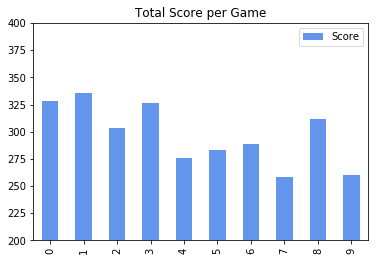

In [12]:
plt.figure()
pd.Series(games.sum(axis='columns'), name='Score')\
  .plot.bar(title='Total Score per Game', ylim=(200,400), color='cornflowerblue')
plt.legend(loc='best')

<Figure size 432x288 with 0 Axes>

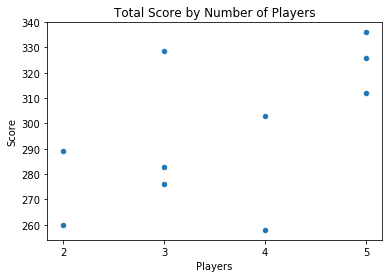

In [13]:
plt.figure()
pd.DataFrame({'Players': games.count(axis='columns').astype(np.uint8), 'Score': games.sum(axis='columns')})\
  .plot.scatter(x='Players', y='Score', title='Total Score by Number of Players', xticks=range(2, 6))

We normalize each player's scores based on the average player score in a game. E.g., if the total score in a five player game is 300, individual player scores are normalized to 60. Results of any correlation between total score and number of players may require adjustment to this naive normalization method.

We then show summary statistics for each player based on the number of games (`count`) they have played and their normalized scores.

In [14]:
norm_games = games.apply(lambda x: x / x.mean(), axis='columns')
norm_games.describe().fillna('-')

,Allis,AllisTodd,Benjamin,Kevin,Matt,Steve,Todd
count,5.000000,1,8.000000,1,5.000000,9.000000,7.000000
mean,1.049934,0.976744,0.983849,0.769231,1.092918,0.985030,0.971957
std,0.061978,-,0.058294,-,0.090564,0.141279,0.099534
min,0.952381,0.976744,0.877976,0.769231,1.029703,0.736196,0.884615
25%,1.043478,0.976744,0.969179,0.769231,1.041667,0.937294,0.897316
50%,1.049470,0.976744,0.985244,0.769231,1.054264,0.961538,0.907738
75%,1.088957,0.976744,1.002717,0.769231,1.088957,1.100346,1.040873
max,1.115385,0.976744,1.085271,0.769231,1.250000,1.220238,1.134969


In [15]:
norm_games.loc[:, games.count() > 1]

,Allis,Benjamin,Matt,Steve,Todd
0,NaN,1.000000,NaN,1.105023,0.894977
1,0.952381,0.877976,1.041667,1.220238,0.907738
2,NaN,0.976898,1.029703,0.937294,1.056106
3,1.088957,0.950920,1.088957,0.736196,1.134969
4,1.043478,1.010870,NaN,0.945652,NaN
5,1.049470,0.975265,NaN,0.975265,NaN
6,NaN,NaN,NaN,1.100346,0.899654
7,NaN,1.085271,1.054264,0.883721,NaN
8,NaN,0.993590,1.250000,0.961538,1.025641
9,1.115385,NaN,NaN,NaN,0.884615


For players who have played more than one game (we really need more...) we estimate the probability density function (PDF) from their normalized scores. Higher / narrower peaks indicate the player has performed more consistently relative to a player with a lower / wider peak. The PDF indicates the probability of the given player performing in a given score range.

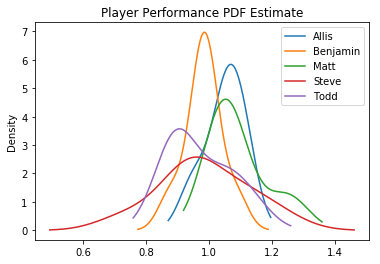

In [16]:
norm_games.loc[:, games.count() > 1].plot.kde(title='Player Performance PDF Estimate')

---
## Naive RedRank

Here we create a naive player rating system by arbitrarily setting each player's initial rating to 100. This corresponds to a _prediction_ that the player will score an average score in the upcoming game. Based on actual game results, we compare the predicted performance with the actual performance and adjust the player's _estimated_ rating by a small amount. E.g., if a player is predicted to score average (a rating of 100), but scores +5%, their new rating will go up by one point to 101. We'll have to tune the adjustment factor based on evaluating much more game data.

In [17]:
SCALE = 100
rr = pd.DataFrame(SCALE, index=[0], columns=norm_games.columns)

def predicted(rr):
    return rr / SCALE

K = 0.20
def rr_delta(predicted, actual):
    return K*(actual - predicted)*SCALE

for index, actual in norm_games.iterrows():
    cur_rr = rr.iloc[index]
    d = rr_delta(predicted(cur_rr), actual).fillna(0)
    new_rr = cur_rr + d
    rr = rr.append(new_rr, ignore_index=True)
    
rr

,Allis,AllisTodd,Benjamin,Kevin,Matt,Steve,Todd
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,100.000000,100.000000,100.000000,100.000000,100.000000,102.100457,97.899543
2,99.047619,100.000000,97.559524,100.000000,100.833333,106.085127,96.474397
3,99.047619,100.000000,97.585573,100.000000,101.260726,103.613976,98.301629
4,101.017236,100.000000,97.086863,100.000000,102.787722,97.615107,101.340690
5,101.683354,100.000000,97.886882,100.000000,102.787722,97.005129,101.340690
6,102.336083,100.000000,97.814806,100.000000,102.787722,97.109404,101.340690
7,102.336083,100.000000,97.814806,100.000000,102.787722,99.694444,99.065632
8,102.336083,99.534884,99.957271,100.000000,103.315449,97.429973,99.065632
9,102.336083,99.534884,99.837612,95.384615,107.652359,97.174748,99.765326


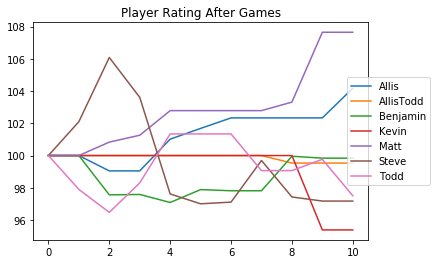

In [18]:
rr.plot(title='Player Rating After Games').legend(loc='center right', bbox_to_anchor=(1.2, 0.5))

In [19]:
positional_rr = rr.rank(axis=1, ascending=False)
positional_rr

,Allis,AllisTodd,Benjamin,Kevin,Matt,Steve,Todd
0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
1,4.0,4.0,4.0,4.0,4.0,1.0,7.0
2,5.0,3.5,6.0,3.5,2.0,1.0,7.0
3,5.0,3.5,7.0,3.5,2.0,1.0,6.0
4,3.0,4.5,7.0,4.5,1.0,6.0,2.0
5,2.0,4.5,6.0,4.5,1.0,7.0,3.0
6,2.0,4.5,6.0,4.5,1.0,7.0,3.0
7,2.0,3.5,7.0,3.5,1.0,5.0,6.0
8,2.0,5.0,4.0,3.0,1.0,7.0,6.0
9,2.0,5.0,3.0,7.0,1.0,6.0,4.0


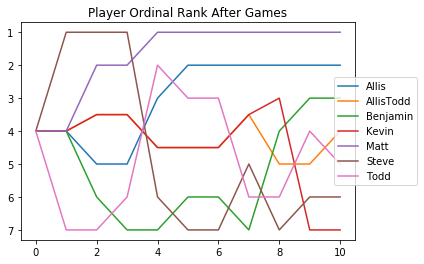

In [20]:
ax = positional_rr.plot(title='Player Ordinal Rank After Games')
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
ax.invert_yaxis()

---
# Current Player Ranking

In [21]:
display(rr.iloc[-1].sort_values(ascending=False))

Matt         107.652359
Allis        104.176558
Benjamin      99.837612
AllisTodd     99.534884
Todd          97.504568
Steve         97.174748
Kevin         95.384615
Name: 10, dtype: float64

---

# TrueSkill

#### Use Microsoft TrueSkill to rate the players

---

In [179]:
import math
from functools import partial
from scipy.stats import norm
from trueskill import global_env, quality_1vs1, rate, setup, Rating, BETA
setup(backend='scipy')

trueskill.TrueSkill(mu=25.000, sigma=8.333, beta=4.167, tau=0.083, draw_probability=10.0%, backend='scipy')

In [180]:
ratings = {n: Rating() for n in games.columns}

In [181]:
def update_ratings(ratings, game):
    game = game.dropna()
    rating_groups = [(ratings[n],) for n in game.index]
    ranks = game.rank(ascending=False).values.astype(int)
    new_ratings = rate(rating_groups, ranks)
    for n, nr in zip(game.index, new_ratings):
        ratings[n] = nr[0]
        
games.apply(partial(update_ratings, ratings), axis='columns')

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
8    None
9    None
dtype: object

## TrueSkill ratings after all games

In [182]:
ratings

{'Allis': trueskill.Rating(mu=29.183, sigma=3.053),
 'AllisTodd': trueskill.Rating(mu=22.134, sigma=4.689),
 'Benjamin': trueskill.Rating(mu=23.367, sigma=2.233),
 'Kevin': trueskill.Rating(mu=15.049, sigma=5.567),
 'Matt': trueskill.Rating(mu=28.214, sigma=2.629),
 'Steve': trueskill.Rating(mu=19.997, sigma=2.304),
 'Todd': trueskill.Rating(mu=25.569, sigma=2.593)}

## Conservative estimate of player strength -- there is a 99% chance your rating is above this level

In [177]:
for n, r in ratings.items():
    print('{}: {:.4}'.format(n, r.mu - 3*r.sigma))

Allis: 20.02
AllisTodd: 8.066
Benjamin: 16.67
Kevin: -1.652
Todd: 17.79
Matt: 20.33
Steve: 13.08


## Player rating estimate curves
### Location of the peak indicates mean player strength estimate, width of curve is the estimate uncertainty

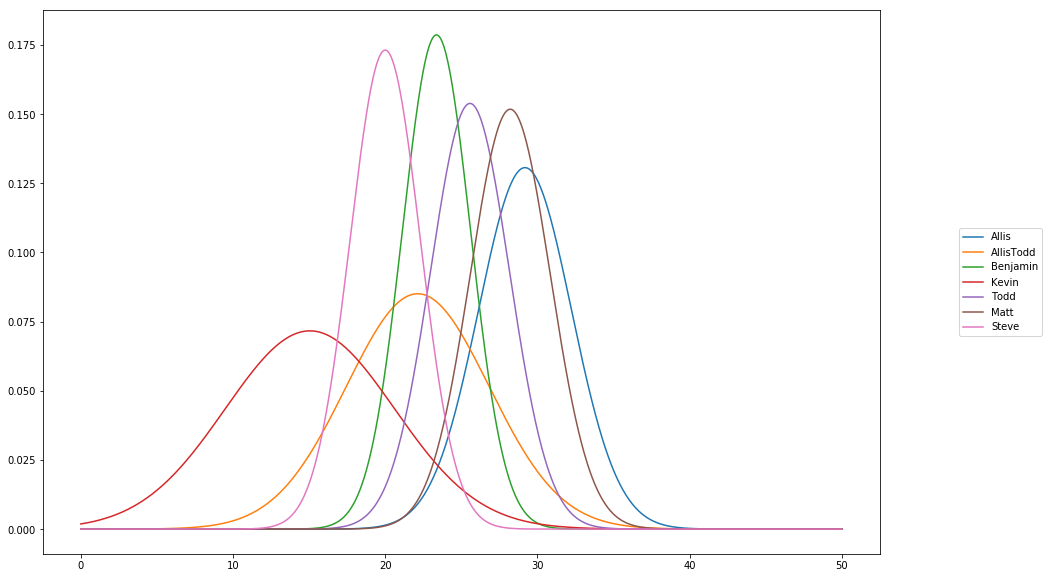

In [170]:
x = np.linspace(0,50,1000)
for n, r in ratings.items():
    plt.plot(x, norm.pdf(x, loc=r.mu, scale=r.sigma), label=n)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))

## Pairwise expected match results based on player rating, which includes rating uncertainty

In [171]:
for n, r in ratings.items():
    print('------------------')
    print(n, r)
    for opp_n, opp_r in ratings.items():
        if n is opp_n:
            continue
        delta_mu = r.mu - opp_r.mu
        sum_sigma = r.sigma ** 2 + opp_r.sigma ** 2
        win_p = global_env().cdf(delta_mu / math.sqrt(2*BETA*BETA + sum_sigma))
        print('  vs {}: {:.1%} chance to win'.format(opp_n, win_p))

------------------
Allis trueskill.Rating(mu=29.183, sigma=3.053)
  vs AllisTodd: 80.7% chance to win
  vs Benjamin: 79.7% chance to win
  vs Kevin: 94.9% chance to win
  vs Todd: 69.4% chance to win
  vs Matt: 55.4% chance to win
  vs Steve: 90.4% chance to win
------------------
AllisTodd trueskill.Rating(mu=22.134, sigma=4.689)
  vs Allis: 19.3% chance to win
  vs Benjamin: 43.8% chance to win
  vs Kevin: 77.5% chance to win
  vs Todd: 33.3% chance to win
  vs Matt: 22.3% chance to win
  vs Steve: 60.7% chance to win
------------------
Benjamin trueskill.Rating(mu=23.367, sigma=2.233)
  vs Allis: 20.3% chance to win
  vs AllisTodd: 56.2% chance to win
  vs Kevin: 83.9% chance to win
  vs Todd: 37.3% chance to win
  vs Matt: 23.9% chance to win
  vs Steve: 69.2% chance to win
------------------
Kevin trueskill.Rating(mu=15.049, sigma=5.567)
  vs Allis: 5.1% chance to win
  vs AllisTodd: 22.5% chance to win
  vs Benjamin: 16.1% chance to win
  vs Todd: 10.8% chance to win
  vs Matt: 6